# Data Preprocessing

## Crime(보이스피싱) Data

In [141]:
# package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

In [93]:
# csv load(7.1s)
KP2020 = pd.read_csv('data/KP2020.csv', encoding='cp949')
KP2021 = pd.read_csv('data/KP2021.csv', encoding='cp949')
NPA2020 = pd.read_csv('data/NPA2020.csv', encoding='cp949')

### 보이스피싱 범죄 Dataset Generate
- 사건코드 : EVT_CL_CD == 215 </br>
- 동일사건 제외 : SME_EVT_YN != Y

In [94]:
KP2020 = KP2020.loc[(KP2020.EVT_CL_CD == 215) & (KP2020.SME_EVT_YN != 'Y'),:]
KP2021 = KP2021.loc[(KP2021.EVT_CL_CD == 215) & (KP2021.SME_EVT_YN != 'Y'),:]
NPA2020 = NPA2020.loc[(NPA2020.EVT_CL_CD == 215) & (NPA2020.SME_EVT_YN != 'Y'),:]

In [95]:
# Datetime 통일
NPA2020['RECV_CPLT_DM'] = None
NPA2020['RECV_CPLT_DM'] = NPA2020['RECV_CPLT_DM'].astype('str')
NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype('str')
NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype('str')

NPA2020['RECV_CPLT_DM'] = [i + j.zfill(6) for i,j in NPA2020[['RECV_CPLT_DT','RECV_CPLT_TM']].values] # 시간 6자리로 코딩 후 병합
NPA2020 = NPA2020[NPA2020.columns.drop(['RECV_CPLT_DT','RECV_CPLT_TM'])]

In [96]:
KP2020['RECV_CPLT_DM'] = pd.to_datetime(KP2020['RECV_CPLT_DM'], yearfirst=True)
KP2021['RECV_CPLT_DM'] = pd.to_datetime(KP2021['RECV_CPLT_DM'], yearfirst=True)
NPA2020['RECV_CPLT_DM'] = pd.to_datetime(NPA2020['RECV_CPLT_DM'], yearfirst=True)

In [97]:
# 사용컬럼만 추출
cols = ['RECV_CPLT_DM', 'NPA_CL', 'RPTER_SEX', 'HPPN_X', 'HPPN_Y']
KP2020 = KP2020[cols]
KP2021 = KP2021[cols]
NPA2020 = NPA2020[cols]

In [98]:
# Merge
df_crime = pd.concat([KP2020, KP2021, NPA2020], axis=0).dropna(axis=0).sort_values(by='RECV_CPLT_DM')
df_crime = df_crime[~(df_crime.HPPN_X == 0)].reset_index(drop=True)

# to GeoDataFrame
gdf_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime['HPPN_X'], df_crime['HPPN_Y']), crs='WGS84')
gdf_crime = gdf_crime[gdf_crime.columns.drop(['HPPN_X','HPPN_Y'])]

In [99]:
gdf_crime = gdf_crime.loc[gdf_crime.NPA_CL.isin([19,13,31]),:] # 충남, 세종, 대전 한정 데이터 추출
gdf_crime.to_file('data/gdf_crime.gpkg')

## Geographic Processing

In [130]:
gdf_crime = gpd.read_file('data/gdf_crime.gpkg')

In [150]:
# 행정구역 data
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949')
sejong = sejong.to_crs('WGS84')

daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949')
daejeon = daejeon.to_crs('WGS84')

chungnam = gpd.read_file('data/ADM_AREA/충남/LSMD_ADM_SECT_UMD_44.shp', encoding='cp949')
chungnam = chungnam.to_crs('WGS84')

whole_area = pd.concat([sejong, daejeon, chungnam], axis=0)

In [152]:
# 각 접수사건 포함 행정구역 추출
from tqdm import tqdm

gdf_crime['ADM_AREA'] = 0 # 충남/세종/대전 지역 외 발생사건은 행정구역 0으로 표기
for i in tqdm(range(len(gdf_crime))):
    arr_i = np.where(whole_area.geometry.intersects(gdf_crime.geometry[i]))[0]
    if len(arr_i) > 0 :
        gdf_crime.ADM_AREA[i] = whole_area.iat[arr_i[0],4] # GID 대입

  0%|          | 0/33926 [00:00<?, ?it/s]/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_30120/1482555074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_crime.ADM_AREA[i] = whole_area.iat[arr_i[0],4]
100%|██████████| 33926/33926 [00:45<00:00, 747.21it/s]


In [153]:
sum(gdf_crime.ADM_AREA == 0) # 590개 > 제외

590

In [156]:
# 대상지역 외 사건 제외
gdf_crime = gdf_crime[~(gdf_crime.ADM_AREA == 0)]

In [157]:
# 각 지역별로 분리
gdf_crime_chungnam = gdf_crime.loc[gdf_crime.ADM_AREA.isin(chungnam.GID),:]
gdf_crime_daejeon = gdf_crime.loc[gdf_crime.ADM_AREA.isin(daejeon.GID),:]
gdf_crime_sejong = gdf_crime.loc[gdf_crime.ADM_AREA.isin(sejong.GID),:]

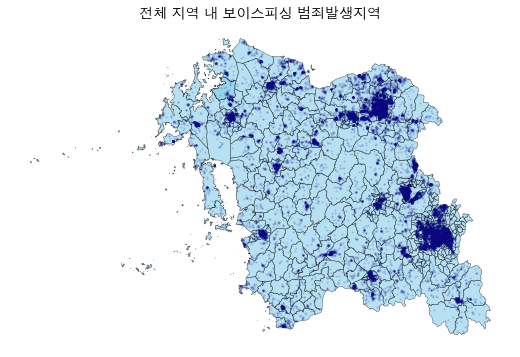

In [160]:
# Plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

whole_area.geometry.plot(ax=ax, zorder=1, color='skyblue', alpha=0.6, edgecolor='black', linewidth=0.5)
gdf_crime.geometry.plot(ax=ax, zorder=2, color='navy', alpha=0.1, markersize=2)

ax.set_axis_off()

plt.title('전체 지역 내 보이스피싱 범죄발생지역', fontsize=14)
plt.show()

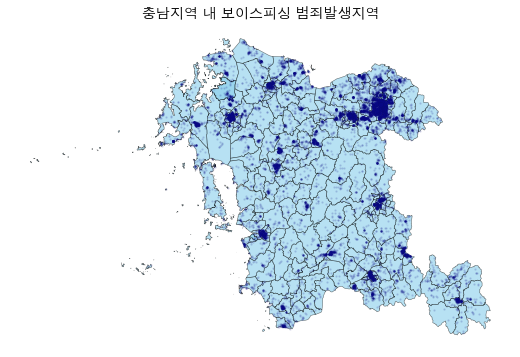

In [161]:
# Plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

chungnam.geometry.plot(ax=ax, zorder=1, color='skyblue', alpha=0.6, edgecolor='black', linewidth=0.5)
gdf_crime_chungnam.geometry.plot(ax=ax, zorder=2, color='navy', alpha=0.1, markersize=2)

ax.set_axis_off()

plt.title('충남지역 내 보이스피싱 범죄발생지역', fontsize=14)
plt.show()

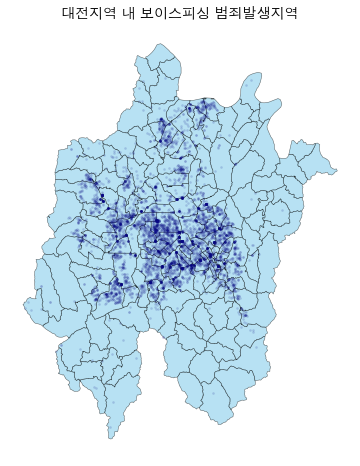

In [165]:
# Plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

daejeon.geometry.plot(ax=ax, zorder=1, color='skyblue', alpha=0.6, edgecolor='black', linewidth=0.5)
gdf_crime_daejeon.geometry.plot(ax=ax, zorder=2, color='navy', alpha=0.1, markersize=3)

ax.set_axis_off()

plt.title('대전지역 내 보이스피싱 범죄발생지역', fontsize=14)
plt.show()

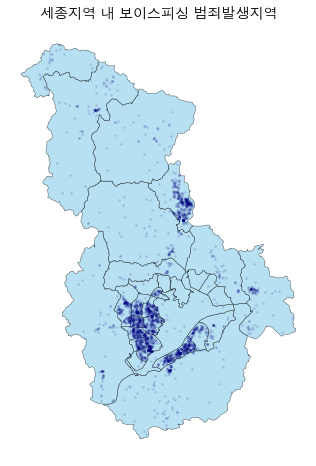

In [166]:
# Plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

sejong.geometry.plot(ax=ax, zorder=1, color='skyblue', alpha=0.6, edgecolor='black', linewidth=0.5)
gdf_crime_sejong.geometry.plot(ax=ax, zorder=2, color='navy', alpha=0.1, markersize=3)

ax.set_axis_off()

plt.title('세종지역 내 보이스피싱 범죄발생지역', fontsize=14)
plt.show()